In [1]:
import numpy as np
import random
from statistics import mean
import matplotlib.pyplot as plt
from matplotlib import colors
from random import randrange 
from copy import deepcopy

In [2]:
#### '0': rock, '1': ground, '2': player, '3': end

import csv 
def save_list(data):
    a = []
    for i in range(len(data)):
        a.append([])
        for j in range(len(data[i])):
            if data[i][j]  == 1:
                a[i].append(' ')
            elif data[i][j]  == 0:
                a[i].append('x')
            elif data[i][j]  == 2:
                a[i].append('p')
            else:
                a[i].append('end')
    with open('map.csv', 'w', newline = '', encoding = 'utf-8') as file:
        writer = csv.writer(file)
        for row in a:
            writer.writerow(row)

In [3]:
choice = lambda x: randrange(0,x)

In [8]:
## This class define a map object, it can create a random map itself, print itself, define a matrix mask which detemine 
## the tile reachable by the player and launch an A* algorithm to find distance between the start and the end

class _map:
    
    def __init__(self, SIZE_X, SIZE_Y):
        self.SIZE_X = SIZE_X
        self.SIZE_Y = SIZE_Y
        self.tiles_walkable = np.ones((self.SIZE_X, self.SIZE_Y))
        self.map_mask  = np.zeros((self.SIZE_X,self.SIZE_Y), dtype = np.int8) # mask: 1 if the tile is in the main path, 0 otherwise
        self.end_reachable = False
        self.distance   =  -1
        self.end_pos    = -1
        self.player_pos = -1
        
    ## Create random map
    def get_random_env(self):
        
        # get player and end's position
        player_pos      = choice(self.SIZE_X), choice(self.SIZE_Y)
        end_pos         = choice(self.SIZE_X), choice(self.SIZE_Y)
        while end_pos == player_pos:
            end_pos = choice(self.SIZE_X), choice(self.SIZE_Y) 
        self.player_pos = player_pos
        self.end_pos    = end_pos
        
        # set all tiles to either 0 (rock) either 1 (walkable path)
        for i in range(self.SIZE_X):  
            for j in range(self.SIZE_Y):
                self.tiles_walkable[i][j] = choice(2)
        self.tiles_walkable[self.player_pos[0]][self.player_pos[1]] = 2
        self.tiles_walkable[self.end_pos[0]][self.end_pos[1]] = 3

        
    ## Print the map  
    def read_map(self):
        _map_list = self.tiles_walkable.tolist()
        cmap = colors.ListedColormap([ 'gold','gray','orange','blue','red'])
        fig, ax = plt.subplots()
        ax.imshow(_map_list, cmap=cmap)
        
        # Major ticks
        ax.set_xticks(np.arange(0, self.SIZE_Y, 1))
        ax.set_yticks(np.arange(0, self.SIZE_X, 1))

        # Labels for major ticks
        ax.set_xticklabels(np.arange(1, self.SIZE_Y+1, 1))
        ax.set_yticklabels(np.arange(1, self.SIZE_X+1, 1))

        # Minor ticks
        ax.set_xticks(np.arange(-.5, self.SIZE_Y, 1), minor=True)
        ax.set_yticks(np.arange(-.5, self.SIZE_X, 1), minor=True)

        # Gridlines based on minor ticks
        ax.grid(which='minor', color='k', linestyle='-', linewidth=2)

        # Remove minor ticks
        ax.tick_params(which='minor', bottom=False, left=False)
        plt.show()
        

    ## Set mask
    # Even if the tile is walkable, the tile can be unreacheable, the mask detect where the player can go in the map
    def set_tile_mask(self, player_pos):
        x, y = player_pos
        self.map_mask[x][y] = 1
        next_pos = [(x+1,y), (x-1,y), (x,y+1), (x,y-1)]
        for new_pos in next_pos:
        
            # out of map
            if new_pos[0]< 0 or new_pos[0] >= self.SIZE_X or new_pos[1]< 0 or new_pos[1] >= self.SIZE_Y:
                pass
            # check for near position if their mask is 0 and their tiles is walkable
            elif (self.map_mask[new_pos[0]][new_pos[1]] ==0 and self.tiles_walkable[new_pos[0]][new_pos[1]]):
                self.set_tile_mask(new_pos)

  

    def clean_mask(self):
        self.map_mask = np.zeros((self.SIZE_X,self.SIZE_Y), dtype = np.int8)
        
    def get_mask(self):
        return self.map_mask
    
    def get_player_pos(self):
        return self.player_pos

    def get_end_pos(self):
        return self.end_pos
    
    def set_end_reachable(self):
        x_end, y_end = self.get_end_pos()
        if self.get_mask()[x_end][y_end]:
            self.end_reachable = True
        else:
            self.end_reachable = False

    ## A* function
    def new_dir(self, array_value,array_value_close,  x, y):
        possible_position = []
            
        # check if inside the map, not visited and not a rock
        if not x == self.SIZE_X-1 and array_value[x+1, y]== np.inf and array_value_close[x+1, y] == np.inf and self.tiles_walkable[x+1][y] != 0: 
            possible_position.append((x+1,y))
            
        if not x == 0 and array_value[x-1, y]== np.inf and array_value_close[x-1, y] == np.inf and self.tiles_walkable[x-1][y] != 0:
            possible_position.append((x-1,y))   
            
        if not y == self.SIZE_Y-1 and array_value[x, y+1]== np.inf and array_value_close[x, y+1] == np.inf and self.tiles_walkable[x][y+1] != 0:
            possible_position.append((x,y+1))
            
        if not y == 0 and array_value[x, y-1]== np.inf and array_value_close[x, y-1] == np.inf and self.tiles_walkable[x][y-1] != 0:
            possible_position.append((x,y-1))
            
        return possible_position
    
    ## A* function
    def evaluate_pos(self, x, y, previous_g_value):
        g_value = previous_g_value +1
        h_value = abs(x-self.end_pos[0])+ abs(y-self.end_pos[1])
        f_value = g_value + h_value
        return f_value, g_value, h_value
            

    # Algorithm A*
    def get_shortest_way(self):

        x, y = self.end_pos
        if self.map_mask[x][y] == 0:
            self.distance = -3
            return -1
        
        else:

   
            array_f_value_open = np.matrix(np.ones((self.SIZE_X,self.SIZE_Y)) * np.inf) # matrix weight unexplored
            array_f_value_close = np.matrix(np.ones((self.SIZE_X,self.SIZE_Y)) * np.inf) # matrix wright explored
            array_g_value = np.zeros((self.SIZE_X,self.SIZE_Y), dtype = np.int8) # contain distance from the inital
            array_h_value = np.zeros((self.SIZE_X,self.SIZE_Y), dtype = np.int8) # matrix distance until the end


            array_f_value_open[self.player_pos[0],self.player_pos[1]] = abs(self.player_pos[0]-self.end_pos[0])+ abs(self.player_pos[1]-self.end_pos[1])
            current_pos = self.player_pos
            
            not_finished = True


            while not_finished:

                x, y = current_pos
                potential_pos = self.new_dir(array_f_value_open, array_f_value_close, x, y)
                
                for pos in potential_pos:
                    
                    f_value, g_value, h_value = self.evaluate_pos(pos[0], pos[1], array_g_value[x][y])
                    array_f_value_open[pos[0], pos[1]] = f_value
                    
                    # check if not inital pos and if it is the first time for this case
                    if array_g_value[pos[0]][pos[1]] == 0 and pos!= self.player_pos:
                        array_g_value[pos[0]][pos[1]] = g_value
                    array_h_value[pos[0]][pos[1]] = h_value
                
                # update the explored positions
                array_f_value_close[x, y] = array_f_value_open[x, y]
                array_f_value_open[x, y] = np.inf
                
                # stop if end is reached
                if current_pos == self.end_pos:
                    
                    not_finished = False
                 
                # updating current position to the minimal weight
                min_array = np.where(array_f_value_open == array_f_value_open.min())
                min_distance_from_end = np.inf
                idx = 0
                
                for _idx, pos in enumerate(zip(min_array[0][:], min_array[1][:])):
                    if array_h_value[pos[0], pos[1]] < min_distance_from_end:
                        idx = _idx
                        min_distance_from_end = array_h_value[pos[0], pos[1]]
                    
                current_pos = min_array[0][idx], min_array[1][idx]
                

                
             
            self.distance = array_f_value_close[self.end_pos[0], self.end_pos[1]]
            return array_f_value_close[self.end_pos[0], self.end_pos[1]]
        
        
    
    
    

In [12]:
class genetic_agent:
    
    def __init__(self, n_map, SIZE_X, SIZE_Y, number_gen, mutation_param = 0.1 ):

        self.n_map          = n_map
        self.SIZE_X         = SIZE_X
        self.SIZE_Y         = SIZE_Y
        self.number_gen     = number_gen
        self.list_maps      = []
        self.current_gen    = 0
        self.list_fitness = []
        self.new_generation = []
        self.mutation_param = mutation_param
 

    def get_random_population(self):
        
        list_maps_init = [_map(self.SIZE_X ,self.SIZE_Y) for _ in range(self.n_map)] # creation of object
        [list_maps_init[i].get_random_env() for i in range(self.n_map)] # fill the map randomly
        [list_maps_init[i].set_tile_mask(list_maps_init[i].get_player_pos()) for i in range(self.n_map)] # fill the mask of the main path
        [list_maps_init[i].set_end_reachable() for i in range(self.n_map)]
        
        self.list_maps = list_maps_init.copy()
    
  
    ## evalute fitness of all maps 
    def eval_fitness(self):

        list_ground_tile= []
        list_dist = []
        for _map in self.list_maps:
            fitness = 0
        
            # check if end is in the main path 
            if not _map.end_reachable:
                fitness -= self.SIZE_X * 5
                
            # check if some walkable tile are not reachable
            for pos, tile_is_reachable in np.ndenumerate(_map.get_mask()):
                if _map.tiles_walkable[pos[0], pos[1]] and not tile_is_reachable :
                    fitness -= 1
                          
            # check proportion of ground tile
            ideal_percentage = 65
            nb_ground_tile = np.count_nonzero(_map.tiles_walkable == 1)
            nb_tile = self.SIZE_X * self.SIZE_Y
            percent = (nb_ground_tile/nb_tile)*100
            list_ground_tile.append(percent)
            diff = abs(percent - ideal_percentage)
            fitness -= diff
            
            # check distances between objectives
            ideal_dist = self.SIZE_X * 5
            dist = _map.get_shortest_way() # return -1 if not reachable
            if dist>0:
                list_dist.append(dist)
            diff = abs(dist - ideal_dist)
            fitness -= diff*2

            # add fitness to the list    
            self.list_fitness.append(fitness) 
        
        self.mean_fitness = mean(self.list_fitness)
        self.mean_ground_tile = mean(list_ground_tile)
        self.mean_dist = mean(list_dist)

        
    
    def crossover(self):
        
        # Create a parent quality list
        min_fitness = min(self.list_fitness)
        eps = 1e-10
        # From their fitness, create a probabilty of selection for each map
        list_bias = [1-self.list_fitness[i]/min_fitness + eps for i in range(self.n_map)]
       
        
        # Creation of n_map map
        for idx_child in range(self.n_map):
            
            # Selection of parents
            idx_parent_1, idx_parent_2 = random.choices(range(self.n_map), list_bias, k = 2)
            _map1 = self.list_maps[idx_parent_1]
            _map2 = self.list_maps[idx_parent_2]

            # Creation of empty child
            _map_child = _map(self.SIZE_X, self.SIZE_Y)

            # Region crossover 
            vertical_blend = choice(2)
            if vertical_blend: # vertical crossover
                nb_row = choice(self.SIZE_Y)
                _map_child.tiles_walkable[nb_row:][:] = _map1.tiles_walkable[nb_row:][:]
                _map_child.tiles_walkable[:nb_row][:] = _map2.tiles_walkable[:nb_row][:]
                
            else:              # horizontal crossover
                nb_col = choice(self.SIZE_X)
                _map_child.tiles_walkable[:][nb_col:] = _map1.tiles_walkable[:][nb_col:]
                _map_child.tiles_walkable[:][:nb_col] = _map2.tiles_walkable[:][:nb_col]
            
            # erase entrance and exit in order to not have several of them
            for i in range(self.SIZE_X):
                for j in range(self.SIZE_Y):
                    if _map_child.tiles_walkable[i][j] in [2, 3]:
                        _map_child.tiles_walkable[i][j] = choice(2)
                
                    
            # Local Crossover 
            #for i in range(self.SIZE_X):
            #    for j in range(self.SIZE_Y):
 
            #       tile = _map1.tiles_walkable[i][j] if choice(2) else _map2.tiles_walkable[i][j]
                    # if entry or end change it to regular tile
            #        if tile in [2, 3]:
             #           tile = 1 if choice(2) else 0
            #        _map_child.tiles_walkable[i][j] = tile
            
            
            # Choose one entrance and one exit
            token1 = choice(2)
            token2 = choice(2)
            new_player_x, new_player_y = _map1.get_player_pos() if token1 else _map2.get_player_pos()
            new_end_x,  new_end_y = _map1.get_end_pos() if token2 else _map2.get_end_pos()
            
            # if tiles have the same position, take the other parent's position or take it randomly
            if (new_end_x,  new_end_y) == (new_player_x, new_player_y):
                new_end_x,  new_end_y = _map2.get_end_pos() if token2 else _map1.get_end_pos() 
            while (new_end_x,  new_end_y) == (new_player_x, new_player_y):
                    new_end_x = choice(self.SIZE_X)
                    new_end_y = choice(self.SIZE_Y)
                    
            # set entrance and exit      
            _map_child.tiles_walkable[new_player_x][new_player_y] = 2
            _map_child.tiles_walkable[new_end_x][new_end_y] = 3  
            _map_child.player_pos =(new_player_x, new_player_y)
            _map_child.end_pos = (new_end_x, new_end_y)

            # Create a new mask (where the player can go)
            _map_child.clean_mask()
            _map_child.set_tile_mask((new_player_x, new_player_y))

            self.new_generation.append(_map_child)
            
    
        
        
    def mutation(self):

        for idx_child in range(self.n_map):
            
            _m = deepcopy(self.new_generation[idx_child])
            x_player, y_player = _m.get_player_pos()
            x_end, y_end = _m.get_end_pos()

            # choisir size du patch parcourir avec ce patch, mettre à 1 ou 0 sur le patch
            mutation_param = self.mutation_param
            sizeX, sizeY   = self.SIZE_X, self.SIZE_Y
            
            # mutation patch
            vertical = choice(2)
            patch_mutation_size = sizeX//5 
            length = choice(patch_mutation_size)+1
            mutation_walkable = choice(2)
            
            if vertical:
                
                for i in range(0,sizeX- length +1, patch_mutation_size):
                    for j in range(0, sizeY, 1):
                        if random.random() < mutation_param: 
                            for add in range(length):   
                                _m.tiles_walkable[i+add][j] = mutation_walkable
 
                
            else:
                
                for i in range(0,sizeX):
                    for j in range(0, sizeY - length +1,patch_mutation_size ):
                        if random.random() < mutation_param: 
                            for add in range(length):   
                                _m.tiles_walkable[i][j+add] = mutation_walkable
                        

            # check if entrance and exit         
            if 2 not in _m.tiles_walkable:
                x_player = choice(sizeX)
                y_player = choice(sizeY)
                _m.tiles_walkable[x_player][y_player] = 2
                _m.player_pos = (x_player, y_player)
                
            if 3 not in _m.tiles_walkable:
                while (x_end, y_end) == (x_player, y_player):
                    x_end = choice(sizeX)
                    y_end = choice(sizeY)
                _m.tiles_walkable[x_end][y_end] = 3
                _m.end_pos = (x_end, y_end)
            
            _m.clean_mask()
            _m.set_tile_mask((x_player, y_player))
            _m.set_end_reachable()
                
            self.new_generation[idx_child] = deepcopy(_m)

                    
        
        
        
        
    


In [13]:
# initialisation
agent = genetic_agent(n_map = 500,SIZE_X = 20, SIZE_Y =20, number_gen = 3000, mutation_param = 0.0020)

START

generation:  50


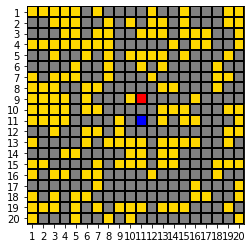

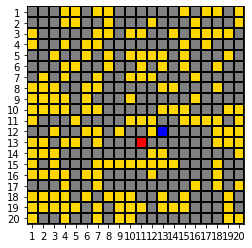

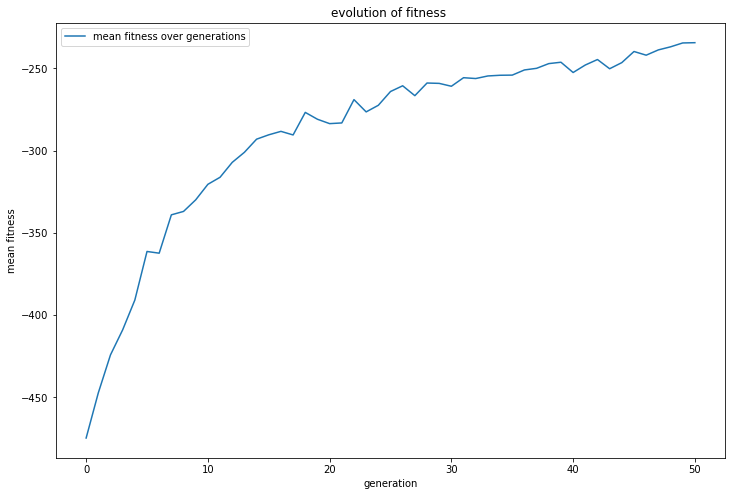

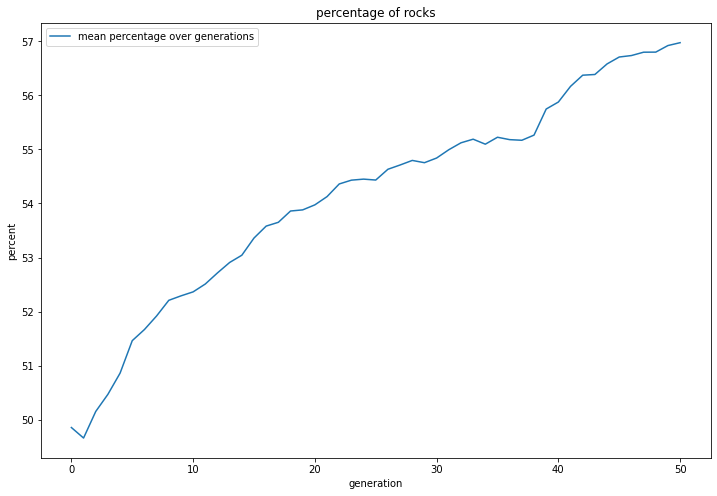

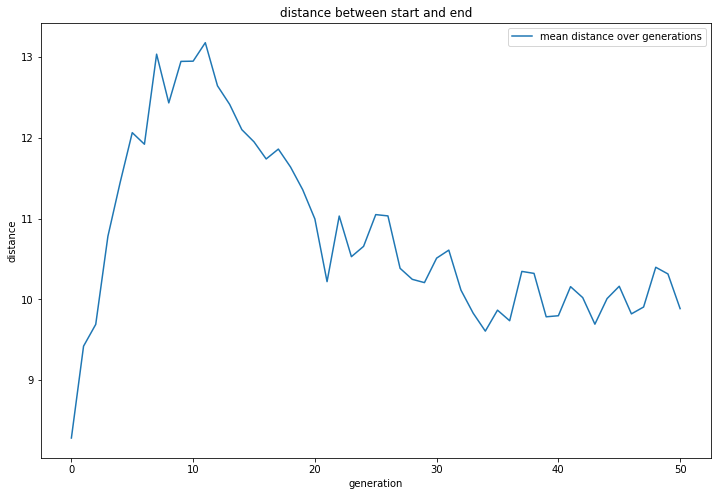


generation:  100


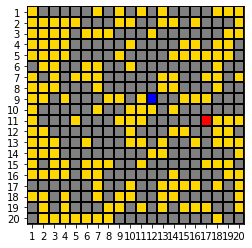

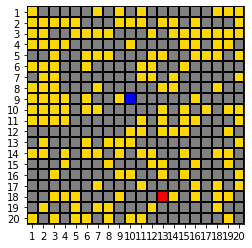

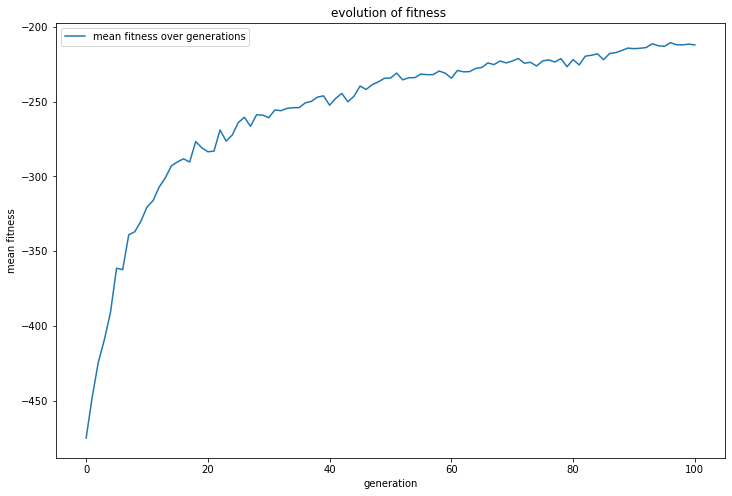

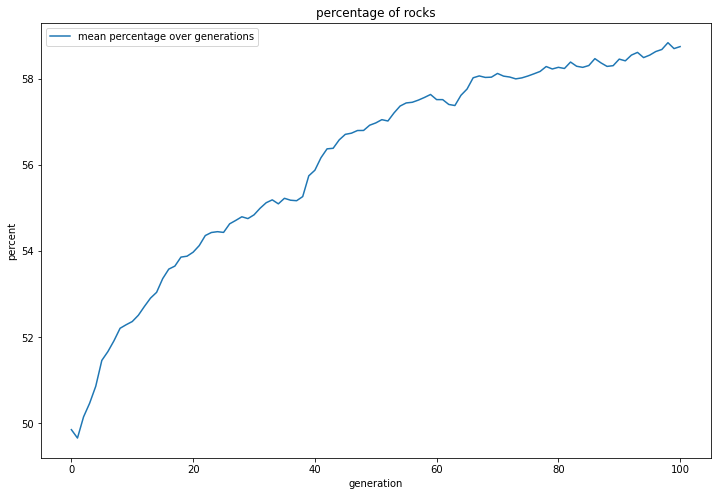

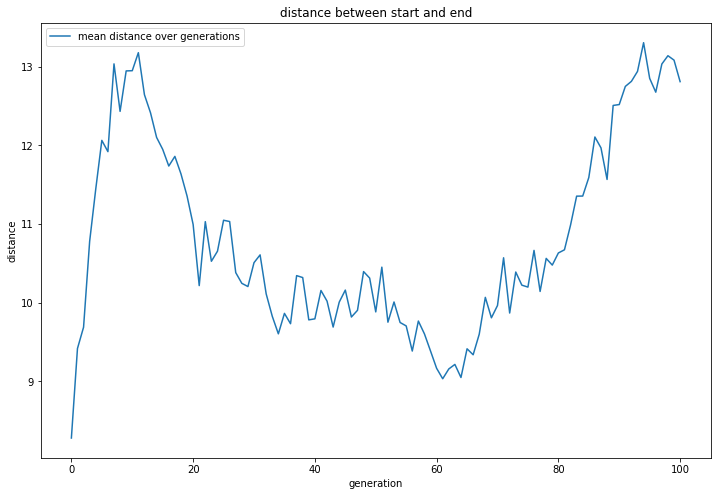


generation:  150


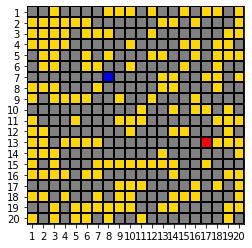

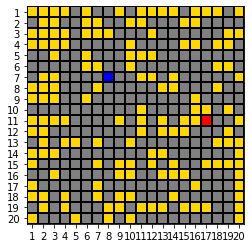

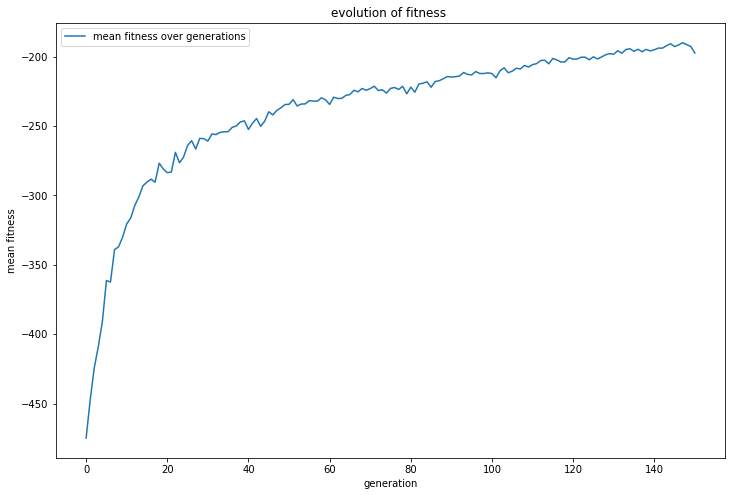

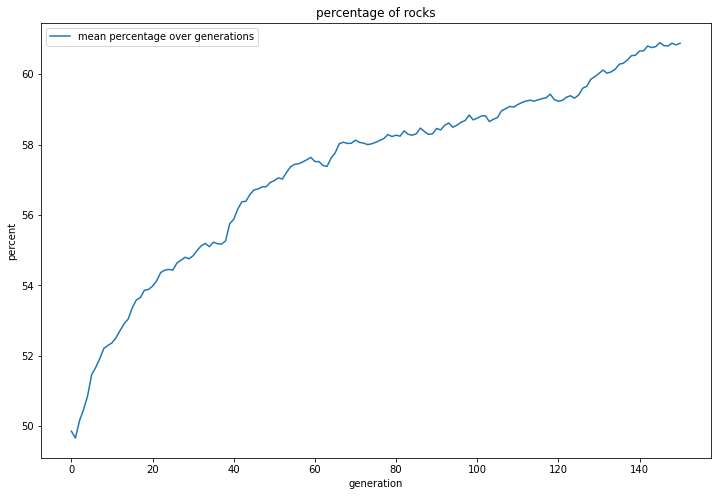

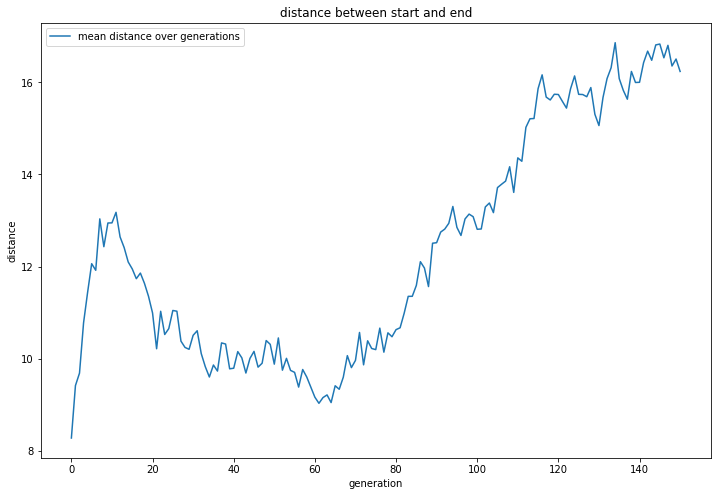

In [ ]:
agent.get_random_population()

fitness_to_draw = []
ground_tile_to_draw = []
dist_to_draw = []
print("START")
for gen in range(agent.number_gen):

    l = agent.list_maps

    agent.eval_fitness()
    agent.crossover()
    agent.mutation()

    fitness_to_draw.append(agent.mean_fitness)
    ground_tile_to_draw.append(agent.mean_ground_tile)
    dist_to_draw.append(agent.mean_dist)

    if agent.current_gen%50==0 and agent.current_gen!=0:
        print("\ngeneration: ",agent.current_gen)
        l[0].read_map()
        l[1].read_map()

        fig_fitness = plt.figure(figsize=(12,8))
        plt.plot(range(gen+1), fitness_to_draw)
        plt.title("evolution of fitness ")
        plt.xlabel('generation')
        plt.ylabel('mean fitness')
        plt.legend(['mean fitness over generations'])
        fig_fitness.savefig('Graph/fitnessGeneration_'+str(agent.current_gen))
        plt.show()
        
        
        fig_percentage = plt.figure(figsize=(12,8))
        plt.plot(range(gen+1), ground_tile_to_draw)
        plt.title("percentage of rocks")
        plt.xlabel('generation')
        plt.ylabel('percent')
        plt.legend(['mean percentage over generations'])
        fig_percentage.savefig('Graph/percentRocks_'+str(agent.current_gen))
        plt.show()

        fig_distance = plt.figure(figsize=(12,8))
        plt.plot(range(gen+1), dist_to_draw)
        plt.title("distance between start and end")
        plt.xlabel('generation')
        plt.ylabel('distance')
        plt.legend(['mean distance over generations'])
        plt.savefig('Graph/distance_'+str(agent.current_gen))
        plt.title("distance between start and end")
        plt.show()

    # remise à 0
    agent.current_gen +=1
    agent.list_maps = agent.new_generation.copy()
    agent.new_generation.clear()
    agent.list_fitness.clear()

print("final")
plt.plot(range(agent.number_gen), fitness_to_draw)
plt.show()
plt.plot(range(agent.number_gen), ground_tile_to_draw)
plt.show()
for _l in l:
    _l.read_map()

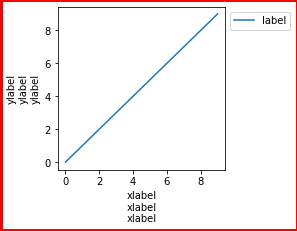

In [65]:
plt.figure(figsize=[3,3],linewidth=5,edgecolor='r') 
ax =plt.subplot()
ax.plot(range(10),range(10),label='label')
ax.set_xlabel('xlabel\nxlabel\nxlabel')
ax.set_ylabel('ylabel\nylabel\nylabel')
ax.legend(bbox_to_anchor=[1,1])   

plt.savefig('tight_layout.png',bbox_inches='tight')

In [ ]:
[0].read_map()
        l[1].read_map()
        
        fig_fitness = plt.figure(figsize=(15,10))
        plt.plot(range(gen+1), fitness_to_draw)
        plt.title("evolution of fitness ")
        plt.xlabel('generation')
        plt.ylabel('mean fitness')
        plt.legend(['mean fitness over generations'])
        
        


        fig_fitness.savefig('Graph/fitnessGeneration_'+str(agent.current_gen))
        plt.show()
        
        fig_percentage = plt.figure(figsize=(15,10))
        plt.plot(range(gen+1), ground_tile_to_draw)
        plt.title("percentage of rocks")
        plt.xlabel('generation')
        plt.ylabel('percent')
        plt.legend(['mean percentage over generations'])
        fig_percentage.savefig('Graph/percentRocks_'+str(agent.current_gen))
        plt.show()
        
        fig_distance = plt.figure(figsize=(15,10))
        plt.plot(range(gen+1), dist_to_draw)
        plt.title("distance between start and end")
        plt.xlabel('generation')
        plt.ylabel('distance')
        plt.legend(['mean distance over generations'])
        plt.savefig('Graph/distance_'+str(agent.current_gen))